In [1]:
%matplotlib inline
%run 'bin/notebook_utils.py'
%run 'bin/plot_utilization.py'
import matplotlib.ticker as mticker
import radical.entk as re

In [2]:
! radical-stack


  python               : 3.7.7
  pythonpath           : 
  virtualenv           : /Users/mturilli/Virtualenvs/princeton-pa

  radical.analytics    : 0.90.7-v0.72.0-44-ge31c6b0@fix-plot_origin
  radical.entk         : 1.0.2
  radical.pilot        : 1.4.1
  radical.saga         : 1.3.0
  radical.utils        : 1.4.0



In [3]:
suds = ['re.session.login1.hrlee.018425.0026']
sdir = '../data/raw/incite/'
sids = [sdir+s for s in suds]

In [4]:
ss = {}
for sid in suds:
    sp = sdir+sid
    ss[sid] = {'s': ra.Session(sp, 'radical.pilot')}
    ss[sid].update({'p': ss[sid]['s'].filter(etype='pilot'   , inplace=False),
                    'u': ss[sid]['s'].filter(etype='unit'    , inplace=False),
                    't': ss[sid]['s'].filter(etype='task'    , inplace=False),
                    'w': ss[sid]['s'].filter(etype='pipeline', inplace=False)})

In [5]:
for sid in suds:
    ss[sid].update({'sid'   : ss[sid]['s'].uid,
                    'pid'   : ss[sid]['p'].list('uid'),
                    'npilot': len(ss[sid]['p'].get()),
                    'lm'    : ss[sid]['s'].get(etype='pilot')[0].cfg['agent_launch_method'],
                    'npact' : len(ss[sid]['p'].timestamps(state='PMGR_ACTIVE')),
                    'nunit' : len(ss[sid]['u'].get()),
                    'nudone': len(ss[sid]['u'].timestamps(state='DONE')),
                    'nufail': len(ss[sid]['u'].timestamps(state='FAILED'))})
    ss[sid].update({'pres'  : ss[sid]['p'].get(uid=ss[sid]['pid'])[0].description['resource'],
                    'ncores': ss[sid]['p'].get(uid=ss[sid]['pid'])[0].description['cores'],
                    'ngpus' : ss[sid]['p'].get(uid=ss[sid]['pid'])[0].description['gpus']})                  
    ss[sid].update({'nnodes': ss[sid]['ngpus']/6})

In [6]:
for sid in suds:
    print("""
%s:
\tName of the HPC platform: %s
\tPilot launch method: %s
\tNumber of pilots requested: %i
\tNumber of pilots active: %i
\tNumber of requested cores: %i
\tNumber of requested GPUs: %s
\tNumber of requested nodes: %s
\tNumber of nodes asked by ENTK: %i
\tNumber of tasks executed by EnTK: %i
\tNumber of tasks successfully executed by EnTK: %i
\tNumber of failed tasks: %i
""" % (sid              , ss[sid]['pres']  , ss[sid]['lm'], 
       ss[sid]['npilot'], ss[sid]['npact'] , ss[sid]['ncores']/4, 
       ss[sid]['ngpus'] , ss[sid]['nnodes'], ss[sid]['ncores']/168, 
       ss[sid]['nunit'] , ss[sid]['nudone'], ss[sid]['nufail']))


re.session.login1.hrlee.018425.0026:
	Name of the HPC platform: ornl.summit
	Pilot launch method: JSRUN
	Number of pilots requested: 1
	Number of pilots active: 1
	Number of requested cores: 840
	Number of requested GPUs: 120
	Number of requested nodes: 20.0
	Number of nodes asked by ENTK: 20
	Number of tasks executed by EnTK: 496
	Number of tasks successfully executed by EnTK: 361
	Number of failed tasks: 15



In [7]:
metrics_default = [

        # pilot overheads (global)
        ['Pilot Startup',     ['boot', 'setup_1']],
        ['Pilot Termination', ['term' ]],

        # derived pilot durations
        ['Agent Nodes',       ['agent']],
        ['Warmup',            ['warm' ]],
        ['Draining',          ['drain']],
        ['Idle',              ['idle' ]],

        # unit durations (PRTE)
        ['Prepare Exec',      ['exec_queue', 'exec_prep']],
        ['Exec RP',           ['exec_rp', 'exec_sh', 'term_sh', 'term_rp']],
        ['Exec Cmd',          ['exec_cmd']],
        ['Unschedule',        ['unschedule']],
]

In [8]:
# get utilization information
# FIXME: remove bogus session
suds = ['re.session.login1.hrlee.018425.0026']
sdir = '../data/raw/incite/'
sids = [sdir+s for s in suds]

sobjs = ra.Experiment(sids, stype='radical.pilot')
provided, consumed, stats_abs, stats_rel, info = sobjs.utilization(metrics=metrics_default)

cache read failed: [Errno 2] No such file or directory: '/Users/mturilli/.radical/analytics/cache//re.session.login1.hrlee.018425.0026.pickle'


In [9]:
# x-axis labels
xkeys = list()

# get the numbers we actually want to plot
for session in sobjs.sessions:

    n_units = len(session.get(etype='unit'))
    
    p_size = 0
    for pilot in session.get(etype='pilot'):
        p_size += pilot.description['cores']

    xkeys.append('%s / %s' % (n_units, p_size))

In [10]:
def update_ticks(x, pos):
    return int(x/168)

/Users/mturilli/Virtualenvs/princeton-pa/lib/python3.7/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


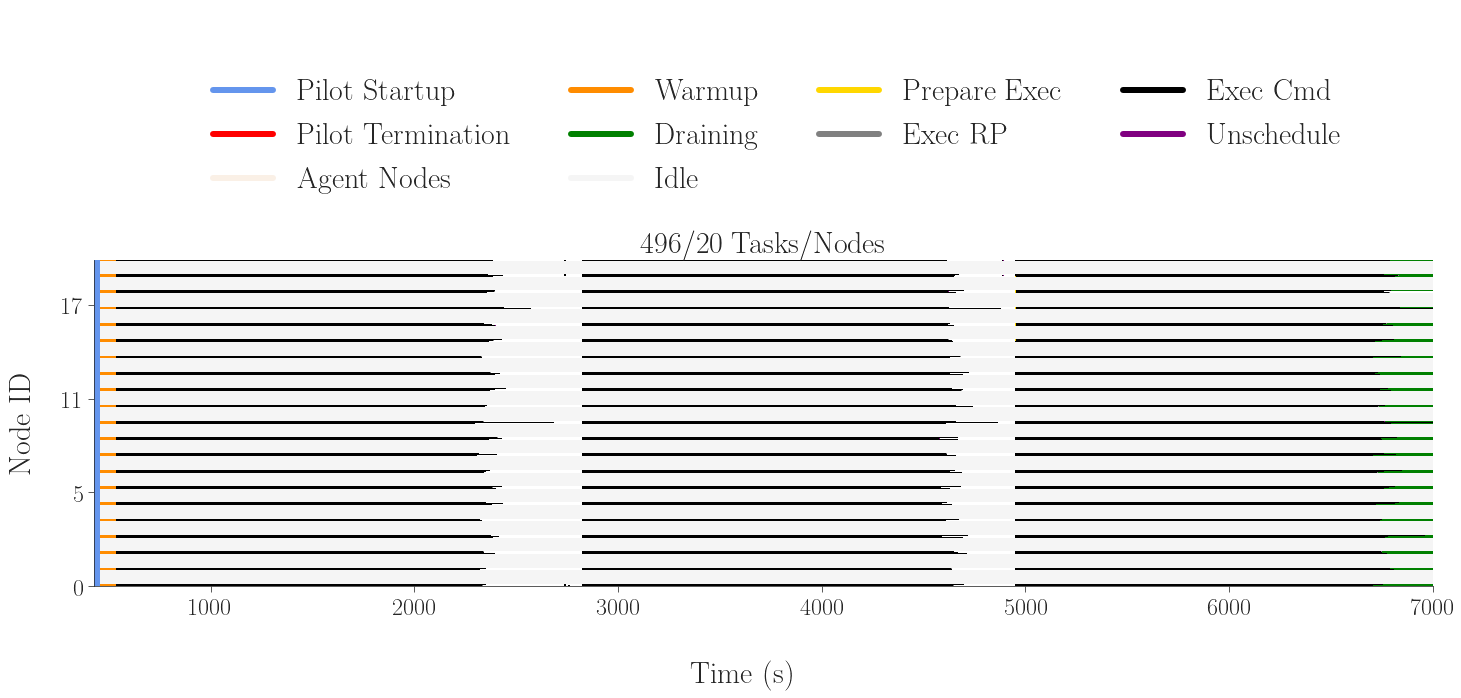

In [11]:
# core/gpu utilization over time (box plot)
import matplotlib.colors as mcolors

fig, ax  = fig_setup(figsize=(24,6))

cmap = mpl.cm.get_cmap('tab20c')

step = 1.0 / (len(metrics_default) + 1)
this = step / 1.0
legend = list()

x_min = None
x_max = None
y_min = None
y_max = None

sid = 're.session.login1.hrlee.018425.0026'
ax.set_title('496/20 Tasks/Nodes', fontdict={'fontsize': 30})

colors = {0: mcolors.CSS4_COLORS['cornflowerblue'], # pilot startup
          1: mcolors.CSS4_COLORS['red'],            # pilot termination
          2: mcolors.CSS4_COLORS['linen'],         # agent nodes
          3: mcolors.CSS4_COLORS['darkorange'],         # warmup
          4: mcolors.CSS4_COLORS['green'],          # Draining
          5: mcolors.CSS4_COLORS['whitesmoke'],          # idle
          6: mcolors.CSS4_COLORS['gold'],         # prepare exec
          7: mcolors.CSS4_COLORS['gray'],           # exec rp
          8: mcolors.CSS4_COLORS['black'],          # exec cmd
          9: mcolors.CSS4_COLORS['purple']}          # unschedule

ccounter = 0
for metric in metrics_default:

    color = colors[ccounter]# cmap(this)
    this += step

    legend.append(mpl.lines.Line2D([0], [0], color=color, lw=6))

    if isinstance(metric, list):
        name = metric[0]
        parts = metric[1]
    else:
        name = metric
        parts = [metric]

    for part in parts:
        for uid in consumed[sid][part]:
            for block in consumed[sid][part][uid]:
                orig_x = block[0]
                orig_y = block[2] - 0.5
                width = block[1] - block[0]
                height = block[3] - block[2] + 1.0

                if x_min is None:
                    x_min = orig_x
                if x_max is None:
                    x_max = orig_x + width
                if y_min is None:
                    y_min = orig_x
                if y_max is None:
                    y_max = orig_x + height

                x_min = min(x_min, orig_x)
                y_min = min(y_min, orig_y)
                x_max = max(x_max, orig_x + width)
                y_max = max(y_max, orig_y + height)

                patch = mpl.patches.Rectangle((orig_x, orig_y),
                                              width, height,
                                              facecolor=color,
                                              edgecolor='black',
                                              fill=True, lw=0.0)
                ax.add_patch(patch)
    
    ccounter += 1

# The session did not close cleanly. EnTK waited for ~800 seconds before deciding 
# that the pilot had died. After that, it closed the sesison and exited. This is 
# a degenerate run and, as such, not representative of the actual overheads on 
# properly terminated sessions. We then normalize the plot to account for such a
# condition. The analysis can be replicated by looking at the profile files in 
# the data/raw directory of this repository.
# ax.set_xlim([x_min, x_max])
ax.set_xlim([x_min, 7000])
ax.set_ylim([y_min, y_max])

# ax.set_xlabel('(%s)' % j, labelpad=45)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(update_ticks))


# Add common axes lables
fig.text(0.075,  0.5, 'Node ID' , va='center', rotation='vertical', fontsize=30)
fig.text(0.5 , -0.1, 'Time (s)', ha='center', fontsize=30)
    
# Add legend
fig.legend(legend, [m[0] for m in metrics_default], loc='upper center', 
           bbox_to_anchor=(0.45, 1.5), fontsize=30, ncol=4)

plt.savefig('figures/incite2020_deepdrivemd.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/incite2020_deepdrivemd.png', dpi=300, bbox_inches='tight')

In [12]:
 print(info[sid])

re.session.login1.hrlee.018425.0026 [496]
    Pilot Startup       :     105125.147     0.420%      ['boot', 'setup_1']
    Pilot Termination   :          0.000     0.000%   !  ['term']
    Agent Nodes         :          0.000     0.000%   !  ['agent']
    Warmup              :      46793.517     0.187%      ['warm']
    Draining            :     497597.646     1.987%      ['drain']
    Idle                :   20636447.584    82.411%      ['idle']
    Prepare Exec        :       1912.244     0.008%      ['exec_queue', 'exec_prep']
    Exec RP             :        169.358     0.001%      ['exec_rp', 'exec_sh', 'term_sh', 'term_rp']
    Exec Cmd            :    3306455.000    13.204%      ['exec_cmd']
    Unschedule          :        112.058     0.000%      ['unschedule']
    total               :   25040832.644   100.000%      

    total               :   25040832.644   100.000%
    over                :   24594612.554    98.218%
    work                :          0.000     0.000%
    m